In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pykalman import KalmanFilter

np.random.seed(42)

In [2]:
# Load data
file_path = '/Users/annapham/Downloads/FilteredDailyMood_anonymized.xlsx'
df = pd.read_excel(file_path)

# Get a list of all patient IDs
patient_ids = df['user_name'].unique()

# Create a dictionary to store results
results = {}

# Iterate through each patient
for patient_id in patient_ids:
    print(f"\n--- Analyzing Patient: {patient_id} ---")
    
    # Filter the DataFrame for that patient
    patient_df = df[df['user_name'] == patient_id].copy()

    rating_cols = [
        "depressedMood", "fatigue", "fidgeting", "increasedEnergy",
        "rapidSpeech", "irritability"
    ]
    patient_data = patient_df[rating_cols]
    M = patient_data.to_numpy()
    M_masked = np.ma.masked_invalid(M) 

    T, obs_dim = M.shape
    latent_dim = 2
    
    # Initial model parameters
    F0 = np.array([[0.5, 0.2], [0.0, 0.5]])
    H0 = np.array([[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.5, 0.5]])
    Q0 = 0.01 * np.eye(latent_dim)
    R0 = 0.1 * np.eye(obs_dim)
    x0 = np.zeros(latent_dim)
    P0 = np.eye(latent_dim)
    h0 = np.zeros(latent_dim)
    
    # Kalman Filter setup
    kf = KalmanFilter(
        transition_matrices=F0,
        observation_matrices=H0,
        transition_covariance=Q0,
        observation_covariance=R0,
        transition_offsets=h0,
        initial_state_mean=x0,
        initial_state_covariance=P0,
        em_vars=[
            'transition_matrices', 'transition_offsets',
            'transition_covariance', 'observation_covariance', 'initial_state_mean'
        ]
    )
    
    # EM loop
    kf = kf.em(M_masked, n_iter=200)

    # Estimate latent states
    U_filt, _ = kf.filter(M_masked)
    U_smooth, _ = kf.smooth(M_masked)

    # Store learned parameters and other relevant data
    results[patient_id] = {
        'A': np.round(kf.observation_matrices, 2),
        'B': np.round(kf.transition_matrices, 2),
        'Sigma': np.round(kf.observation_covariance, 2),
        'Gamma': np.round(kf.transition_covariance, 2),
        'h': np.round(kf.transition_offsets, 2),
        'U_smooth': U_smooth,
        'U_filt': U_filt
    }
    
    # Calculate steady-state mean and eigenvalues
    B = kf.transition_matrices
    h = kf.transition_offsets
    I = np.identity(B.shape[0])
    try:
        mu = np.linalg.inv(I - B) @ h
        eigenvalues, eigenvectors = np.linalg.eig(B)
        results[patient_id]['mu'] = np.round(mu, 2)
        results[patient_id]['eigenvalues'] = np.round(eigenvalues, 2)
        results[patient_id]['eigenvectors'] = eigenvectors

    except np.linalg.LinAlgError:
        print("Cannot compute steady-state mean. The matrix (I - B) is not invertible.")
        results[patient_id]['mu'] = None
        results[patient_id]['eigenvalues'] = None
        results[patient_id]['eigenvectors'] = None 

    
# Try calling some results
print("\n--- Summary of Results for all Patients ---")
for patient_id, data in results.items():
    print(f"\nPatient ID: {patient_id}")
    print("Observational Matrix A:\n", data['A'])
    print("Transition Matrix (B):\n", data['B'])
    print("Observational Noise (Sigma):\n", data['Sigma'])
    print("Transitional Noise (Gamma):\n", data['Gamma'])
    print("Transition Offsets (h):", data['h'])
    print("Steady-State Mean (mu):", data['mu'])
    print("Eigenvalues:", data['eigenvalues'])
    print("Eigenvectors:", data['eigenvectors'])


--- Analyzing Patient: a ---

--- Analyzing Patient: b ---

--- Analyzing Patient: c ---

--- Analyzing Patient: d ---

--- Analyzing Patient: e ---

--- Analyzing Patient: f ---

--- Analyzing Patient: g ---

--- Analyzing Patient: h ---

--- Analyzing Patient: i ---

--- Analyzing Patient: j ---

--- Analyzing Patient: k ---

--- Analyzing Patient: l ---

--- Analyzing Patient: m ---

--- Analyzing Patient: n ---

--- Analyzing Patient: o ---

--- Analyzing Patient: p ---

--- Analyzing Patient: q ---

--- Analyzing Patient: r ---

--- Analyzing Patient: s ---

--- Analyzing Patient: t ---

--- Analyzing Patient: u ---

--- Analyzing Patient: v ---

--- Analyzing Patient: w ---

--- Analyzing Patient: y ---

--- Analyzing Patient: x ---

--- Analyzing Patient: z ---

--- Analyzing Patient: aj ---

--- Analyzing Patient: bk ---

--- Analyzing Patient: ch ---

--- Analyzing Patient: de ---

--- Analyzing Patient: em ---

--- Analyzing Patient: fw ---

--- Analyzing Patient: gi ---

--

In [3]:
# Collect results into a list of dicts
summary_list = []
for patient_id, data in results.items():
    row = {
        "PatientID": patient_id,
        "A": data['A'].tolist() if data['A'] is not None else None,
        "B": data['B'].tolist() if data['B'] is not None else None,
        "Sigma": data['Sigma'].tolist() if data['Sigma'] is not None else None,
        "Gamma": data['Gamma'].tolist() if data['Gamma'] is not None else None,
        "h": data['h'].tolist() if data['h'] is not None else None,
        "Mu (steady state mean)": data['mu'].tolist() if data['mu'] is not None else None,
        "Eigenvalues": data['eigenvalues'].tolist() if data['eigenvalues'] is not None else None,
        "Eigenvectors": data['eigenvectors'].tolist() if data['eigenvectors'] is not None else None,
    }
    summary_list.append(row)

# Convert to DataFrame
summary_df = pd.DataFrame(summary_list)

# Save to CSV
summary_df.to_csv('summary_parameters.csv')

print(summary_df.head())

  PatientID                                                  A  \
0         a  [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0...   
1         b  [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0...   
2         c  [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0...   
3         d  [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0...   
4         e  [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0...   

                                B  \
0  [[0.96, -0.45], [2.08, -0.82]]   
1   [[0.66, 0.58], [-0.05, 0.41]]   
2  [[0.07, -0.03], [-0.73, 0.79]]   
3  [[0.42, -1.24], [-0.01, 0.12]]   
4   [[1.04, -0.26], [0.25, 0.54]]   

                                               Sigma  \
0  [[0.35, 0.1, -0.08, -0.23, -0.28, -0.02], [0.1...   
1  [[0.51, 0.43, -0.29, -0.06, -0.12, 0.43], [0.4...   
2  [[0.04, -0.06, 0.01, -0.01, -0.01, -0.0], [-0....   
3  [[0.7, 0.99, 0.51, -0.0, 0.01, -0.09], [0.99, ...   
4  [[0.39, -0.21, -0.17, 0.04, -0.11, -0.31], [-0...   

                            Gamma          

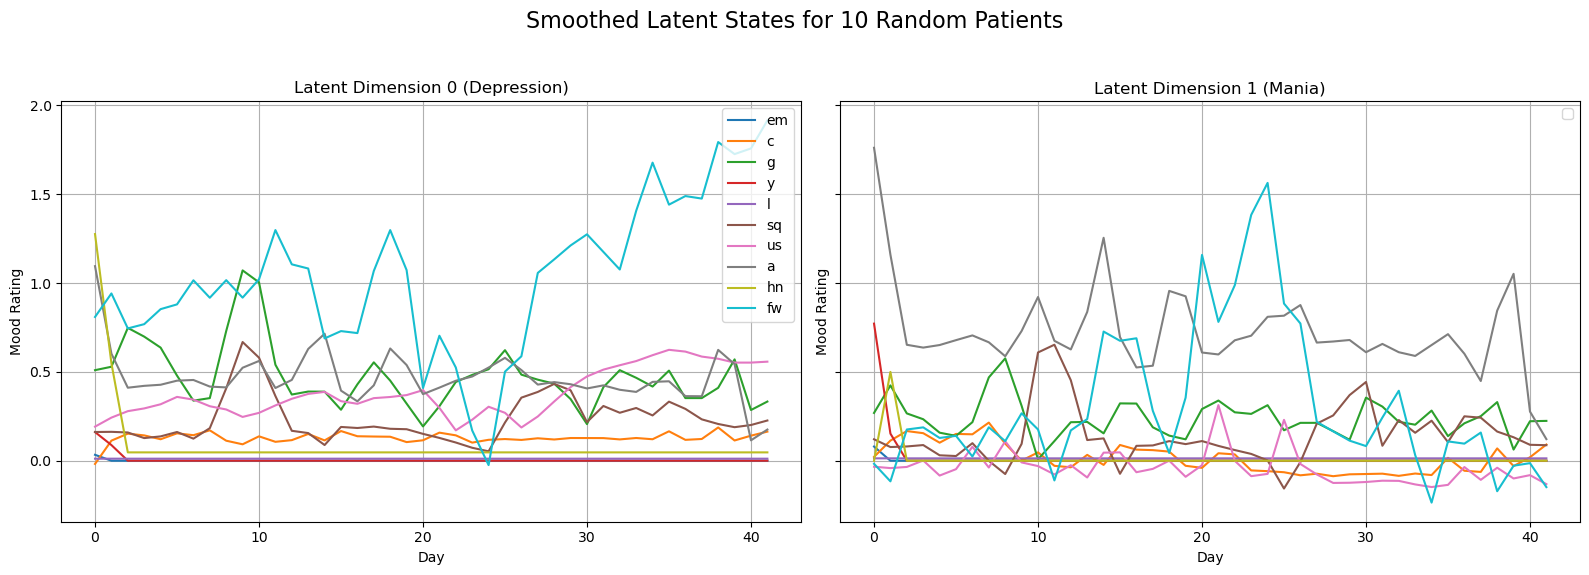

In [4]:
import random
import matplotlib.pyplot as plt

# Get a list of all patient IDs
all_patient_ids = list(results.keys())

selected_patients = random.sample(all_patient_ids, 10)

labels = {0: "Depression", 1: "Mania"}

# Create a single plot with two subplots, one for each latent dimension
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
fig.suptitle("Smoothed Latent States for 10 Random Patients", fontsize=16)
colors = plt.colormaps.get_cmap('tab10')

for i, patient_id in enumerate(selected_patients):
    data = results[patient_id]
    U_smooth = data['U_smooth']
    
    # Plot the smoothed trajectory
    axes[0].plot(U_smooth[:, 0], color=colors(i), linestyle='-', label=f'{patient_id}')
    axes[1].plot(U_smooth[:, 1], color=colors(i), linestyle='-')

axes[0].set_title(f"Latent Dimension 0 ({labels[0]})")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Mood Rating")
axes[0].grid(True)
axes[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

axes[1].set_title(f"Latent Dimension 1 ({labels[1]})")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Mood Rating")
axes[1].grid(True)
axes[1].legend([], [])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
exclude_ids = {}  # set of patients to drop
filtered_patients = [pid for pid in all_patient_ids if pid not in exclude_ids]

# Collect stability values
stab_data = []
for pid in filtered_patients:
    B = results[pid]['B']
    eigvals, _ = np.linalg.eig(B)
    stab = 1 - np.max(np.abs(eigvals))   # stability index
    stab_data.append({"patient_id": pid, "stability_index": stab})

# Put in a table for easy inspection
stab_df = pd.DataFrame(stab_data).set_index("patient_id").sort_values("stability_index")

# Show the results
print(stab_df)

            stability_index
patient_id                 
nx                -4.942507
j                 -0.190571
n                 -0.046805
m                 -0.044179
mg                -0.022793
fw                 0.003756
u                  0.067479
x                  0.070385
v                  0.073618
jr                 0.081948
s                  0.088741
k                  0.100646
pl                 0.114224
us                 0.130855
bk                 0.140582
aj                 0.177765
c                  0.180770
de                 0.203457
e                  0.208419
w                  0.222881
r                  0.230000
o                  0.262057
p                  0.267538
f                  0.267538
it                 0.267538
rt                 0.267538
qj                 0.287611
z                  0.311959
sq                 0.315529
em                 0.320294
g                  0.328658
h                  0.330523
lf                 0.338260
ch                 0

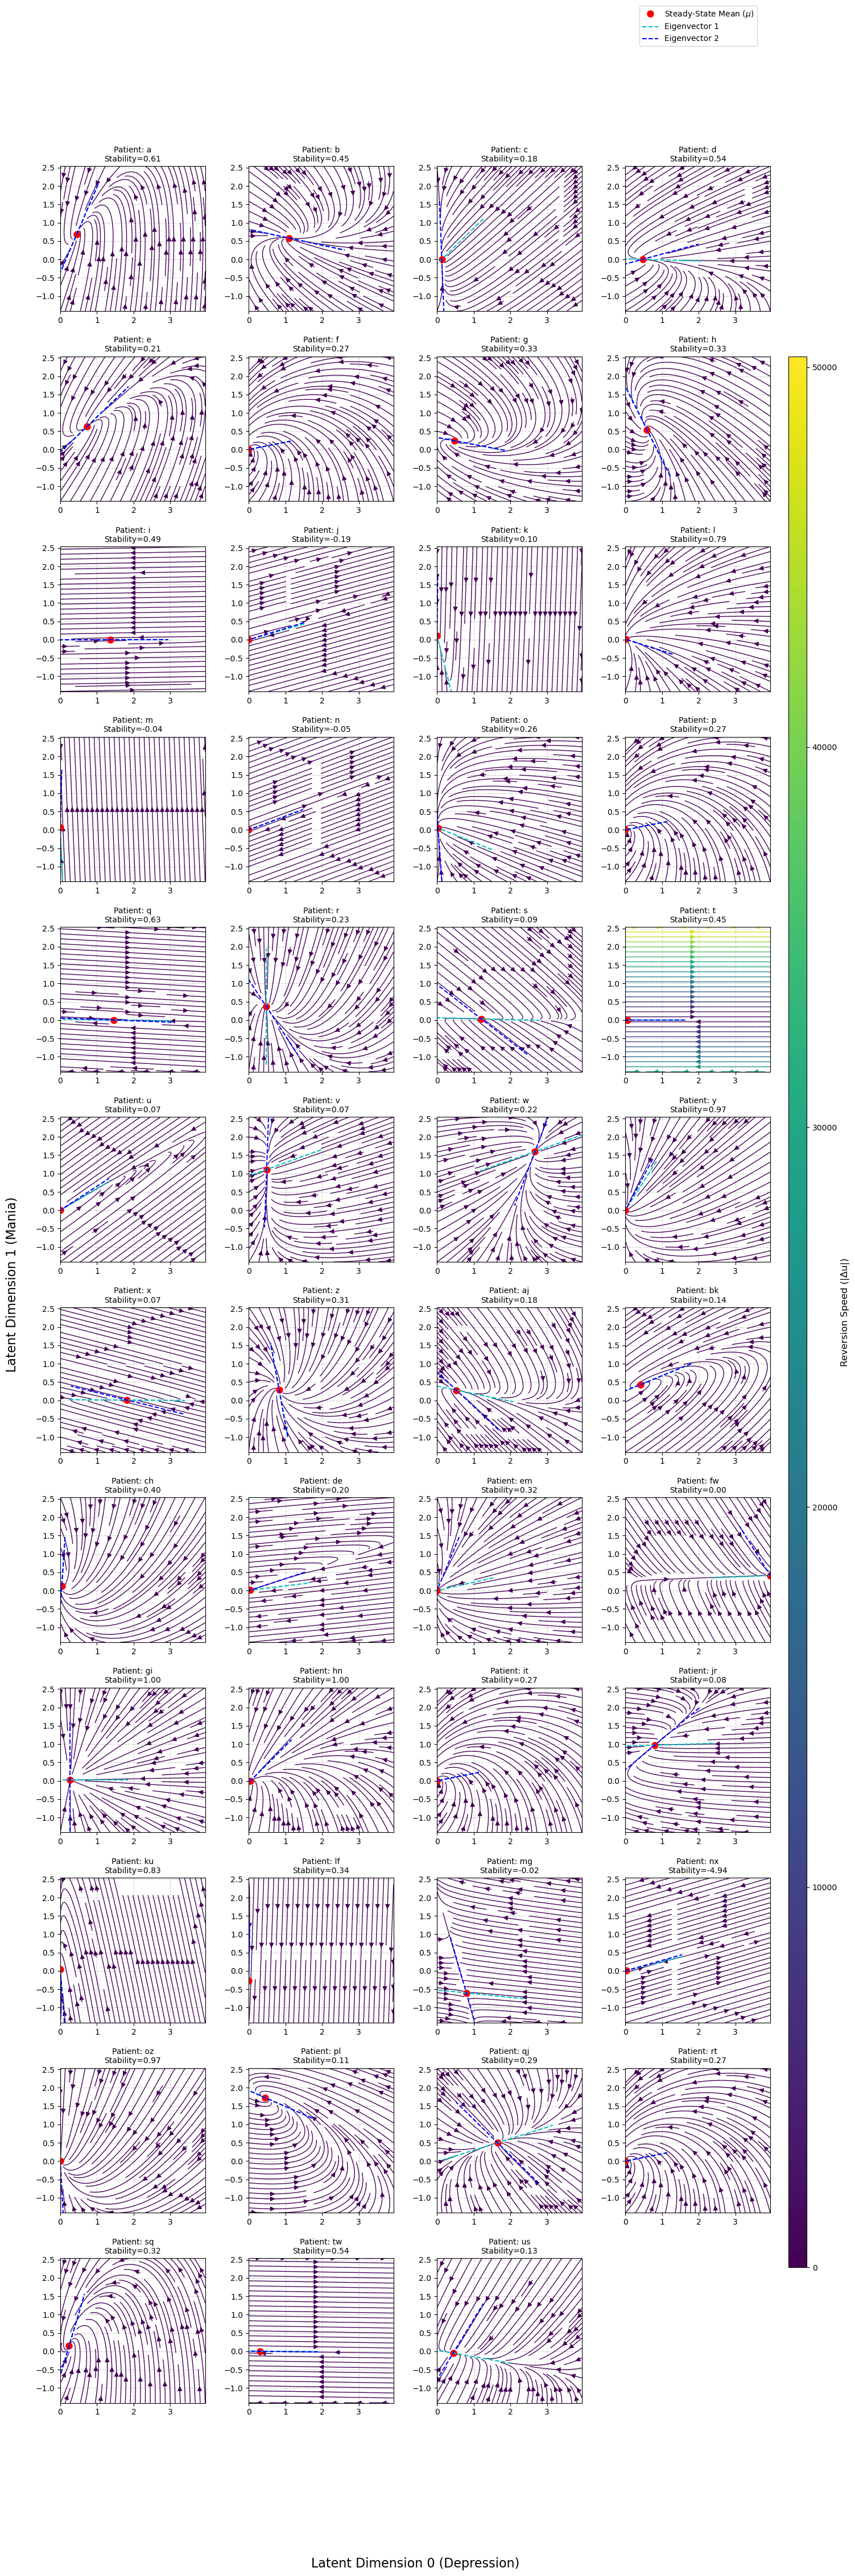

In [6]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import math
import numpy as np

# 1. Remove outlier patients
exclude_ids = {}  # set of outlier patients to drop
filtered_patients = [pid for pid in all_patient_ids if pid not in exclude_ids]

# ---------------------------------------------------
# 2. Compute global mean range
mus = np.array([results[pid]['mu'] for pid in filtered_patients])  # shape (N, 2)
mu_min = mus.min(axis=0)  # [min_x, min_y]
mu_max = mus.max(axis=0)  # [max_x, max_y]

# Find square bounds
mu_center = (mu_min + mu_max) / 2
span = max(mu_max - mu_min)  # take the larger dimension
pad = 0.5 * (span if span > 0 else 1.0)  # add padding
x_min, x_max = mu_center[0] - pad, mu_center[0] + pad
y_min, y_max = mu_center[1] - pad, mu_center[1] + pad

# ---------------------------------------------------
# Grid for streamplots (square)
grid_n = 30
x_range = np.linspace(x_min, x_max, grid_n)
y_range = np.linspace(y_min, y_max, grid_n)
Xg, Yg = np.meshgrid(x_range, y_range)

# Layout
cols = 4
rows = math.ceil(len(filtered_patients) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

cmap = plt.cm.viridis
I2 = np.eye(2)

# Global normalization for colorbar
all_magnitudes = []
for pid in filtered_patients:
    B = results[pid]['B']
    h = results[pid]['h']
    U_grid = np.array([Xg.ravel(), Yg.ravel()])
    U_change = (B - I2) @ U_grid + h[:, np.newaxis]
    mag = np.hypot(U_change[0, :], U_change[1, :])
    all_magnitudes.extend(mag)

# Use... percentile instead of absolute max
vmax = np.percentile(all_magnitudes, 100)
norm = Normalize(vmin=0, vmax=vmax)

# ---------------------------------------------------
# Plot each patient
for i, pid in enumerate(filtered_patients):
    ax = axes[i]
    mu = results[pid]['mu']
    B  = results[pid]['B']
    h  = results[pid]['h']
    eigvals, eigvecs = np.linalg.eig(B)

    # Stability index
    stability_index = 1 - np.abs(eigvals).max()

    # Vector field
    U_grid = np.array([Xg.ravel(), Yg.ravel()])
    U_change = (B - I2) @ U_grid + h[:, np.newaxis]
    Ux = U_change[0, :].reshape(Xg.shape)
    Uy = U_change[1, :].reshape(Yg.shape)
    Umag = np.hypot(Ux, Uy)

    strm = ax.streamplot(
        Xg, Yg, Ux, Uy,
        density=1.0,
        color=Umag,
        cmap=cmap,
        linewidth=1.0,
        arrowsize=1.2,
        norm=norm
    )
    strm.lines.set_cmap(cmap); strm.lines.set_norm(norm)
    strm.arrows.set_cmap(cmap); strm.arrows.set_norm(norm)

    # Steady-state mean
    ax.plot(mu[0], mu[1], 'ro', markersize=8, label=r'Steady-State Mean ($\mu$)')

    # Eigenvectors
    v1, v2 = eigvecs[:, 0].real, eigvecs[:, 1].real
    scale = max(x_max - x_min, y_max - y_min) * 0.4
    ax.plot([mu[0]-scale*v1[0], mu[0]+scale*v1[0]],
            [mu[1]-scale*v1[1], mu[1]+scale*v1[1]], 'c--', lw=1.5, label='Eigenvector 1')
    ax.plot([mu[0]-scale*v2[0], mu[0]+scale*v2[0]],
            [mu[1]-scale*v2[1], mu[1]+scale*v2[1]], 'b--', lw=1.5, label='Eigenvector 2')

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_aspect('equal')
    ax.grid(True, ls='--', alpha=0.6)
    ax.set_title(f"Patient: {pid}\nStability={stability_index:.2f}", fontsize=10)

# Remove unused axes
for j in range(len(filtered_patients), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout margins
fig.subplots_adjust(left=0.10, right=0.88, bottom=0.10, top=0.92, wspace=0.30, hspace=0.30)

# Shared labels
fig.text(0.49, 0.04, f"Latent Dimension 0 ({labels.get(0, 'Depression')})", ha='center', fontsize=16)
fig.text(0.04, 0.51, f"Latent Dimension 1 ({labels.get(1, 'Mania')})", va='center', rotation='vertical', fontsize=16)

# Legend
handles, labels_list = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_list, loc='upper right', bbox_to_anchor=(0.87, 0.98))

# Colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Reversion Speed (|Δu|)", fontsize=12)


plt.show()

In [7]:
import pandas as pd
import numpy as np

def create_mu_dataframe(results):
    data = []
    for patient_id, patient_data in results.items():
        # Use .get() to safely access 'mu' in case some patients didn't converge
        mu = patient_data.get('mu')
        if mu is not None and mu is not np.nan:
            data.append({
                'Patient ID': patient_id,
                'Steady-State Mean': np.round(mu, 2)
            })
    
    df = pd.DataFrame(data)
    df.set_index('Patient ID', inplace=True)
    
    return df

pd.options.display.float_format = '{:.2f}'.format

print("\n--- Steady-State Mean Results DataFrame ---")
steady_state_df = create_mu_dataframe(results)
print(steady_state_df)



--- Steady-State Mean Results DataFrame ---
           Steady-State Mean
Patient ID                  
a               [0.45, 0.69]
b                [1.1, 0.58]
c                [0.13, 0.0]
d                [0.47, 0.0]
e               [0.73, 0.63]
f                 [0.0, 0.0]
g               [0.47, 0.24]
h               [0.59, 0.54]
i                [1.36, 0.0]
j                 [0.0, 0.0]
k                [0.0, 0.11]
l               [0.01, 0.01]
m                [0.0, 0.06]
n                 [0.0, 0.0]
o               [0.03, 0.05]
p                 [0.0, 0.0]
q                [1.46, 0.0]
r               [0.48, 0.37]
s               [1.21, 0.03]
t                [0.05, 0.0]
u                 [0.0, 0.0]
v               [0.49, 1.11]
w                [2.67, 1.6]
y                 [0.0, 0.0]
x               [1.82, 0.01]
z               [0.83, 0.29]
aj              [0.53, 0.28]
bk              [0.41, 0.43]
ch              [0.04, 0.12]
de              [0.04, 0.01]
em                [0.0, 0.0

In [8]:
# save df to csv

steady_state_df.to_csv('steady_state_means.csv')
